# Assignment B - Jakub Nowak & Mateusz Zbysław
## Taxi Trips (2013-2023) Chicago

Why taxi data from Chicago?
We chose to explore Chicago’s taxi trip dataset after evaluating several open data platforms, including those from Copenhagen, Helsinki, New York, Melbourne, and Sydney. Among these, Chicago provided a rich and well-documented dataset covering multiple years (2013–2023) with granular trip-level details. This dataset enabled us to investigate not only temporal and spatial mobility trends, but also economic and behavioral aspects such as fare dynamics, tipping behavior, and company performance. Additionally, taxi use is something most users can intuitively relate to, which makes it ideal for storytelling on our website.

Why is urban mobility important to understand?
Urban mobility plays a foundational role in how cities function. Understanding when, where, and how people move enables city planners, policymakers, and transportation companies to make informed decisions. Insights into ride demand, trip durations, fare patterns, and spatial densities can inform everything from traffic optimization and transit integration to sustainability strategies and economic policy.

What questions are we trying to answer through this project?

- How has the number of taxi trips evolved year by year?

- How have trip characteristics like fare, duration, distance, and speed changed over time?

- Where are the most frequent pickup and dropoff locations? How have these spatial patterns shifted between 2015 and 2023?

- When (hour/week) are taxis most in demand? Are there consistent daily/weekly patterns?

- How does tipping behavior vary by hour, weekday, and company?

- Where in the city are high-tip zones located?

- Which taxi companies dominate the market, and do they differ in fare or tip behavior?

- What impact did COVID-19 have on trip counts, durations, and passenger behavior?

- What can we forecast about future trends in trip volume and fare prices?

Our goal was to create a clear, engaging, and insightful magazine-style experience for the user—one that goes beyond just visualizing data. We wanted the viewer to scroll through a narrative that feels both intuitive and surprising, discovering meaningful insights about how people move through Chicago by taxi. Ultimately, we want users to walk away curious, informed, and perhaps seeing their own city in a new light—realizing how much everyday data can reveal about the pulse of urban life.

# 2. Basic stats
- Our dataset comes from the Chicago Open Data Portal.
https://data.cityofchicago.org/Transportation/Taxi-Trips-2013-2023-/wrvz-psew/about_data

- Size of the original dataset: ~14.7 million rows, 15 columns
- Temporal coverage: 2013–2023
- Data types: numeric, temporal, geospatial

### Libraries import, global settings

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, Select, CheckboxGroup, CustomJS, DateRangeSlider
from bokeh.layouts import column, row
from bokeh.plotting import figure
import plotly.express as p
import plotly.express as px
from sklearn.linear_model import LinearRegression


In [ ]:
def set_plot_style():
    sns.set_theme(style="whitegrid")
    plt.rcParams.update({
        "figure.figsize": (8, 4),
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "axes.edgecolor": "gray",
        "axes.titleweight": "bold",
        "axes.labelcolor": "black",
        "axes.grid": True,
        "grid.linestyle": "--",
        "grid.alpha": 0.3,
        "axes.facecolor": "white",
        "figure.facecolor": "white",
        "legend.frameon": False,
        "legend.loc": "best",
        "legend.fontsize": 10
    })
    sns.set_palette(sns.color_palette("magma"))
set_plot_style()
PRIMARY_BLUE = "#004e98"
TAXI_YELLOW = "#FFD300"

def basic_barplot(series, title, xlabel="", ylabel="Number of Trips"):
    ax = series.plot(kind="bar", color=TAXI_YELLOW)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.tight_layout()
    plt.show()

pd.options.display.float_format = '{:,.2f}'.format

### Reducing dataset size

To efficiently work with the massive raw Taxi_Trips.csv dataset, we processed the file in chunks, removed unnecessary columns, and sampled only a fraction of the rows. This approach allowed us to drastically reduce the dataset size while preserving a representative subset of the data for analysis. The resulting cleaned dataset is both lightweight and rich enough to support meaningful insights across time, space, and behavior.

That step was initially perfomed in separate notebook.

In [ ]:
input_file = r"E:/Taxi_Trips.csv"
output_file = r"E:/Taxi_Trips_cleaned.csv"
sample_fraction = 0.1  # Default: take 10% of rows from each chunk
chunksize = 1_000_000

columns_to_remove = {
    "Trip ID", "Taxi ID", "Pickup Census Tract", "Dropoff Census Tract",
    "Pickup Community Area", "Dropoff Community Area",
    "Pickup Centroid Location", "Dropoff Centroid  Location"
}

first_chunk = True
chunk_idx = 0

for chunk in pd.read_csv(input_file, chunksize=chunksize):
    chunk_idx += 1
    print(f"Processing chunk {chunk_idx}...")

    chunk = chunk.drop(columns=columns_to_remove.intersection(chunk.columns), errors="ignore")

    # Sample a fraction of rows
    chunk = chunk.sample(frac=sample_fraction, random_state=42)  # random_state for reproducibility

    chunk.to_csv(output_file, mode="w" if first_chunk else "a", index=False, header=first_chunk)
    first_chunk = False
print(f"Done. Processed {chunk_idx} chunks.")

### Dataset import

In [5]:
pathPC = "E:/Taxi_Trips_cleaned.csv"
df = pd.read_csv(
    pathPC,
    low_memory=False
)

Inspection of first and last 5 rows.

In [6]:
df

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
0,06/29/2019 11:00:00 PM,06/29/2019 11:15:00 PM,307.00,0.40,4.75,0.00,0.00,1.00,5.75,Cash,Chicago Taxicab,41.89,-87.63,41.89,-87.63
1,03/31/2023 07:45:00 AM,03/31/2023 08:30:00 AM,"2,161.00",8.98,30.00,0.00,0.00,1.00,31.00,Prcard,Flash Cab,41.76,-87.57,41.66,-87.60
2,09/14/2020 03:15:00 PM,09/14/2020 03:30:00 PM,"1,368.00",2.87,13.75,0.00,0.00,0.00,13.75,Prcard,Flash Cab,41.76,-87.57,41.76,-87.57
3,09/26/2020 12:45:00 AM,09/26/2020 01:00:00 AM,780.00,4.70,15.00,0.00,0.00,0.00,15.00,Cash,Top Cab Affiliation,41.90,-87.63,41.94,-87.66
4,08/21/2022 07:45:00 PM,08/21/2022 08:15:00 PM,"2,004.00",15.45,39.50,9.00,0.00,5.00,54.00,Mobile,Globe Taxi,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14705769,01/07/2015 06:30:00 PM,01/07/2015 06:30:00 PM,0.00,0.00,7.85,2.00,0.00,0.00,9.85,Credit Card,Suburban Dispatch LLC,NaN,NaN,NaN,NaN
14705770,07/31/2015 08:00:00 PM,07/31/2015 08:00:00 PM,0.00,0.00,7.75,1.55,0.00,0.00,9.30,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,NaN,NaN
14705771,08/13/2015 10:15:00 AM,08/13/2015 10:15:00 AM,0.00,0.00,40.05,8.01,0.00,0.00,48.06,Credit Card,Suburban Dispatch LLC,NaN,NaN,NaN,NaN
14705772,09/18/2019 07:45:00 PM,09/18/2019 07:45:00 PM,0.00,0.00,3.50,0.00,0.00,0.00,3.50,Cash,Taxi Affiliation Services,41.88,-87.62,41.88,-87.62


We observe that:
- rows are not sorted by timestamp
- multiple rows do not contain data (NaNs)

## 2.1 Basic info

In [7]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14705774 entries, 0 to 14705773
Data columns (total 15 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Trip Start Timestamp        object 
 1   Trip End Timestamp          object 
 2   Trip Seconds                float64
 3   Trip Miles                  float64
 4   Fare                        float64
 5   Tips                        float64
 6   Tolls                       float64
 7   Extras                      float64
 8   Trip Total                  float64
 9   Payment Type                object 
 10  Company                     object 
 11  Pickup Centroid Latitude    float64
 12  Pickup Centroid Longitude   float64
 13  Dropoff Centroid Latitude   float64
 14  Dropoff Centroid Longitude  float64
dtypes: float64(11), object(4)
memory usage: 1.6+ GB


,Trip Seconds,Trip Miles,Fare,Tips,Tolls,Extras,Trip Total,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
count,"14,703,607.00","14,705,523.00","14,703,761.00","14,703,761.00","12,086,885.00","14,703,761.00","14,703,761.00","13,214,334.00","13,214,334.00","12,955,889.00","12,955,889.00"
mean,853.85,3.89,14.46,1.68,0.01,1.16,17.38,41.90,-87.66,41.90,-87.66
std,"1,322.48",12.37,40.39,3.01,3.83,18.47,45.87,0.04,0.08,0.04,0.06
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,41.65,-87.91,41.65,-87.91
25%,354.00,0.60,6.05,0.00,0.00,0.00,7.25,41.88,-87.66,41.88,-87.66
50%,599.00,1.39,8.50,0.00,0.00,0.00,10.25,41.89,-87.63,41.89,-87.63
75%,"1,029.00",3.78,15.50,2.00,0.00,1.00,18.00,41.91,-87.63,41.91,-87.63
max,"86,399.00","3,460.00","9,900.26",930.00,"6,466.66","9,850.30","9,948.47",42.02,-87.53,42.02,-87.53


We observe that:
- timestamp coulmns are recognized as type of objects similarly, payment type and company
- minimum value of trip duration, trip miles, fare, tips, tools, extras and trip total is 0 which can indicate wrongly registered trips
- range of registered trips is
    Longitude: -87.91 to -87.53
    Latitude: 41.65 to 42.02

## 2.2 Data Cleaning and Preprocessing
- Parsing timestamps
- Creating trip duration, tip rate, average speed
- Handling NaNs
- Filtering outliers (e.g., trips over 100 mph, or 0-mile trips)

In [8]:
df["Trip Start Timestamp"] = pd.to_datetime(
    df["Trip Start Timestamp"],
    format="%m/%d/%Y %I:%M:%S %p",
    errors="coerce"
)
df["Trip End Timestamp"] = pd.to_datetime(
    df["Trip End Timestamp"],
    format="%m/%d/%Y %I:%M:%S %p",
    errors="coerce"
)

df.dropna(subset=["Trip Start Timestamp", "Trip End Timestamp"], inplace=True)

df["trip_duration_min"] = (df["Trip End Timestamp"] - df["Trip Start Timestamp"]).dt.total_seconds() / 60
df["avg_speed_mph"] = df["Trip Miles"] / (df["trip_duration_min"] / 60)
df["tip_rate"] = df["Tips"] / df["Fare"]

df["start_year"] = df["Trip Start Timestamp"].dt.year
df["start_month"] = df["Trip Start Timestamp"].dt.month
df["start_hour"] = df["Trip Start Timestamp"].dt.hour
df["start_weekday"] = df["Trip Start Timestamp"].dt.day_name()
df["end_year"] = df["Trip End Timestamp"].dt.year
df["end_month"] = df["Trip End Timestamp"].dt.month
df["end_hour"] = df["Trip End Timestamp"].dt.hour
df["end_weekday"] = df["Trip End Timestamp"].dt.day_name()

## 2.3 Outlier exploration & handling

Before filtering the data, we conducted an outlier analysis to identify extreme or potentially invalid values. These outliers could distort trends and visualizations if left in.
Here’s what we found across the dataset.

Visual outlier inspection

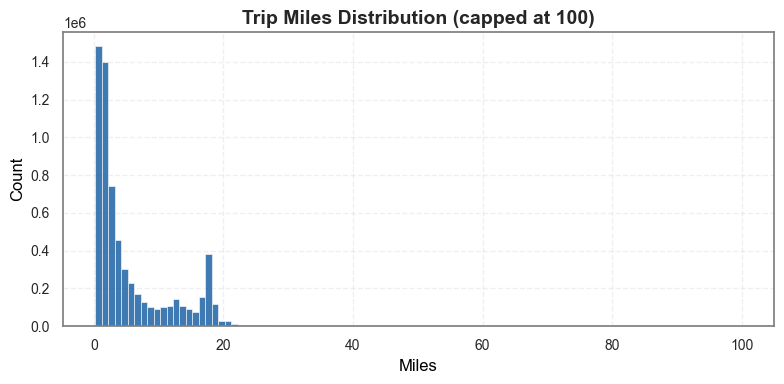

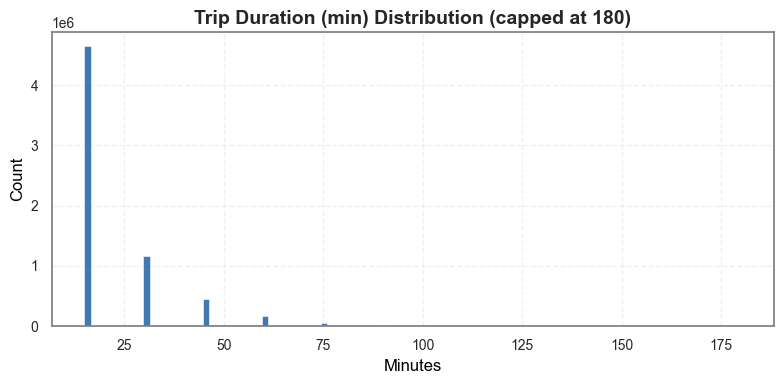

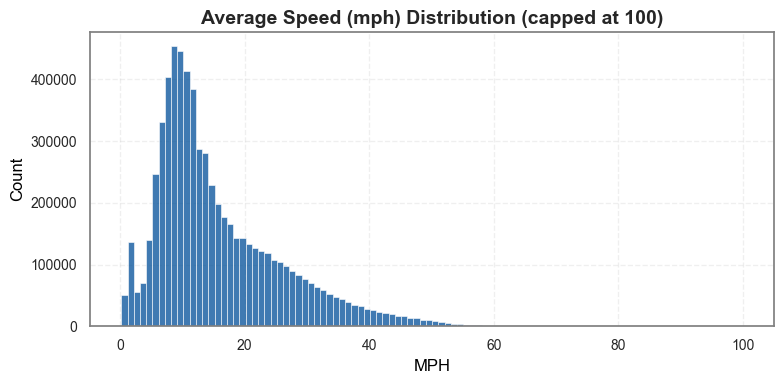

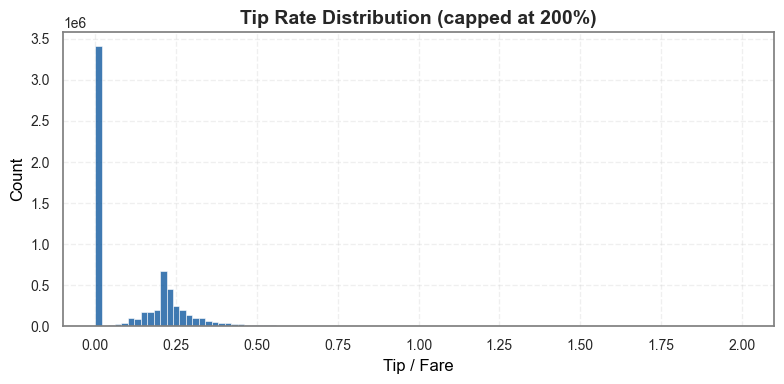

In [48]:
# Helper to cap extreme values
def cap(series, upper):
    return series.clip(upper=upper)

# 1. Trip Miles
sns.histplot(cap(df["Trip Miles"], 100), bins=100, color=PRIMARY_BLUE)
plt.title("Trip Miles Distribution (capped at 100)")
plt.xlabel("Miles")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2. Trip Duration
sns.histplot(cap(df["trip_duration_min"], 180), bins=100, color=PRIMARY_BLUE)
plt.title("Trip Duration (min) Distribution (capped at 180)")
plt.xlabel("Minutes")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 3. Average Speed
sns.histplot(cap(df["avg_speed_mph"], 100), bins=100, color=PRIMARY_BLUE)
plt.title("Average Speed (mph) Distribution (capped at 100)")
plt.xlabel("MPH")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 4. Tip Rate
sns.histplot(cap(df["tip_rate"], 2), bins=100, color=PRIMARY_BLUE)
plt.title("Tip Rate Distribution (capped at 200%)")
plt.xlabel("Tip / Fare")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Quantify outliers

In [ ]:
total = len(df)

zero_miles = df[df["Trip Miles"] < 0.1]
short_duration = df[df["trip_duration_min"] < 1]

too_fast = df[df["avg_speed_mph"] > 100]
too_slow = df[df["avg_speed_mph"] < 1]

huge_fares = df[df["Fare"] > 500]
huge_tips = df[df["Tips"] > 100]

print("Outlier Summary:")
print(f"Zero-mile trips: {len(zero_miles):,} ({len(zero_miles)/total:.2%})")
print(f"Short-duration trips: {len(short_duration):,} ({len(short_duration)/total:.2%})")
print(f"Avg speed > 100 mph: {len(too_fast):,} ({len(too_fast)/total:.2%})")
print(f"Avg speed < 1 mph: {len(too_slow):,} ({len(too_slow)/total:.2%})")
print(f"Fare > $500: {len(huge_fares):,} ({len(huge_fares)/total:.2%})")
print(f"Tips > $100: {len(huge_tips):,} ({len(huge_tips)/total:.2%})")

Outlier Summary:
Zero-mile trips: 2,356,331 (16.02%)
Short-duration trips: 5,340,276 (36.32%)
Avg speed > 100 mph: 3,847,486 (26.16%)
Avg speed < 1 mph: 1,162,758 (7.91%)
Fare > $500: 1,236 (0.01%)
Tips > $100: 117 (0.00%)


We observe a non-trivial number of very slow trips (over 1,162,758, or 7.91%). These likely represent:
- trips with excessive waiting time (e.g. in traffic),
- incorrectly logged durations,
- or short trips left running.

We also found a small number of zero-distance trips, which may stem from GPS logging errors or canceled rides.

## 2.4 Missing Values exploration & handling
To better understand the quality of the dataset before preprocessing, we inspected missing (NaN) values across all columns.

Below is a breakdown of how many values are missing in each column, both in absolute numbers and as a percentage of the full dataset.

This helps identify whether rows should be dropped or whether imputation might be necessary.

- Columns with GPS data (pickup/dropoff coordinates) are often missing — possibly due to technical limitations or privacy masking.
- Financial columns (fare, tips, tolls) rarely contain NaNs but need verification.
- Missing categorical values (like payment type or company) are rare but should be dropped for clean aggregations.

,Column,Missing Values,Percent of All Rows
4,Tolls,2618889,17.81
10,Dropoff Centroid Latitude,1748980,11.89
11,Dropoff Centroid Longitude,1748980,11.89
12,avg_speed_mph,1503922,10.23
8,Pickup Centroid Latitude,1491382,10.14
9,Pickup Centroid Longitude,1491382,10.14
7,Company,1315681,8.95
13,tip_rate,12369,0.08
2,Fare,2013,0.01
3,Tips,2013,0.01


C:\Users\IZO21\AppData\Local\Temp\ipykernel_25256\767962893.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


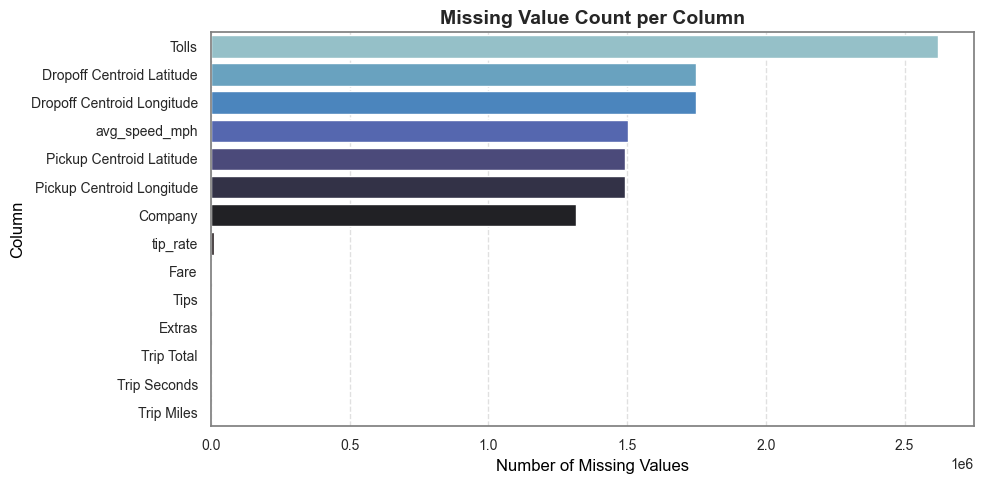

In [11]:
nan_counts = df.isna().sum()
nan_counts = nan_counts[nan_counts > 0]

nan_df = pd.DataFrame({
    "Column": nan_counts.index,
    "Missing Values": nan_counts.values,
    "Percent of All Rows": (nan_counts.values / len(df)) * 100
}).sort_values("Missing Values", ascending=False)

display(nan_df)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=nan_df,
    y="Column", x="Missing Values",
    palette="icefire"
)
plt.title("Missing Value Count per Column")
plt.xlabel("Number of Missing Values")
plt.ylabel("Column")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


Most missing values appear in geospatial (Pickup/Dropoff coordinates) and derived columns like avg_speed_mph and tip_rate. These are expected due to GPS limitations or missing base values and will only be excluded in map-based analysis. Tolls (~18%) is often missing when no toll was paid and will be imputed as 0. The Company field (~9%) may reflect unaffiliated drivers and will be dropped when analyzing company trends. Financial columns (Fare, Tips, Trip Total) and core trip info (Trip Miles, Trip Seconds) have very low missingness and will be dropped when needed.

Strategy:
Drop rows missing critical fields like timestamps, fare, and company. Impute Tolls, Extras, and Tips as 0 where valid. Recalculate derived fields after cleaning. Only filter GPS-related rows in visualizations requiring location data.

## 2.5 Data cleaning - based on exploration

In [12]:
df = df[
    (df["Trip Miles"] >= 0.1) &
    (df["trip_duration_min"] >= 1) &
    (df["trip_duration_min"] <= 180) &
    (df["avg_speed_mph"] >= 1) &
    (df["avg_speed_mph"] <= 100) &
    (df["Fare"] > 0)
]
df["tip_rate"] = df["tip_rate"].clip(upper=1)

df.dropna(subset=["Payment Type", "Company"], inplace=True)

df.reset_index(drop=True, inplace=True)

print("Final cleaned dataset shape:", df.shape)
print(df.dtypes)

C:\Users\IZO21\AppData\Local\Temp\ipykernel_25256\3178864730.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tip_rate"] = df["tip_rate"].clip(upper=1)


Final cleaned dataset shape: (7358897, 26)
Trip Start Timestamp          datetime64[ns]
Trip End Timestamp            datetime64[ns]
Trip Seconds                         float64
Trip Miles                           float64
Fare                                 float64
Tips                                 float64
Tolls                                float64
Extras                               float64
Trip Total                           float64
Payment Type                          object
Company                               object
Pickup Centroid Latitude             float64
Pickup Centroid Longitude            float64
Dropoff Centroid Latitude            float64
Dropoff Centroid Longitude           float64
trip_duration_min                    float64
avg_speed_mph                        float64
tip_rate                             float64
start_year                             int32
start_month                            int32
start_hour                             int32
start_weekda

C:\Users\IZO21\AppData\Local\Temp\ipykernel_25256\3178864730.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=["Payment Type", "Company"], inplace=True)


In [13]:
df["Trip Start Timestamp"].min(), df["Trip End Timestamp"].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2024-01-01 00:45:00'))

In [14]:
df['Tolls'].fillna(0, inplace=True)

df['Extras'].fillna(0, inplace=True)
df['Tips'].fillna(0, inplace=True)

df_cleaned = df.dropna(subset=['Trip Start Timestamp', 'Trip End Timestamp', 'Fare', 'Company', 
                               'Pickup Centroid Latitude', 'Pickup Centroid Longitude', 
                               'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude'])

df_cleaned = df_cleaned.dropna(subset=['Trip Seconds', 'Trip Miles'])

df_cleaned = df_cleaned[(df_cleaned['Fare'] >= 0) & (df_cleaned['Trip Total'] >= 0) & 
                        (df_cleaned['Tips'] >= 0) & (df_cleaned['Tolls'] >= 0)]

df_cleaned = df_cleaned.dropna(subset=['Pickup Centroid Latitude', 'Pickup Centroid Longitude', 
                                       'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude'])

df_cleaned['avg_speed_mph'] = df_cleaned['Trip Miles'] / (df_cleaned['Trip Seconds'] / 3600)
df_cleaned['tip_rate'] = df_cleaned['Tips'] / df_cleaned['Fare']

print(f"NaN values afbefore cleaning:\n{df.isna().sum()}")
print(f"NaN values after cleaning:\n{df_cleaned.isna().sum()}")
df = df_cleaned.copy()

C:\Users\IZO21\AppData\Local\Temp\ipykernel_25256\2828067724.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Tolls'].fillna(0, inplace=True)
C:\Users\IZO21\AppData\Local\Temp\ipykernel_25256\2828067724.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tolls'].fillna(0, inplace=True)
C:\Users\IZO21\AppData\Local\Temp\ipykernel_252

NaN values afbefore cleaning:
Trip Start Timestamp               0
Trip End Timestamp                 0
Trip Seconds                       0
Trip Miles                         0
Fare                               0
Tips                               0
Tolls                              0
Extras                             0
Trip Total                         0
Payment Type                       0
Company                            0
Pickup Centroid Latitude      520679
Pickup Centroid Longitude     520679
Dropoff Centroid Latitude     719761
Dropoff Centroid Longitude    719761
trip_duration_min                  0
avg_speed_mph                      0
tip_rate                           0
start_year                         0
start_month                        0
start_hour                         0
start_weekday                      0
end_year                           0
end_month                          0
end_hour                           0
end_weekday                        0
dtype: i

# 3. Data analysis

## 3.1 Initial basic exploration

A. General trip overview

In [15]:
print("Total valid trips:", len(df))
print(df[["Fare", "Trip Miles", "Trip Total", "tip_rate"]].describe())

Total valid trips: 6505971
              Fare   Trip Miles   Trip Total     tip_rate
count 6,505,971.00 6,505,971.00 6,505,971.00 6,505,971.00
mean         18.12         5.61        21.42         0.14
std          25.98         6.05        31.01         4.52
min           0.01         0.25         0.01         0.00
25%           7.85         1.30         9.25         0.00
50%          11.65         2.70        13.50         0.00
75%          25.75         8.00        28.50         0.22
max       9,006.87       225.00     9,672.11     4,900.00


B. Temporal trends

In [16]:
df.columns

Index(['Trip Start Timestamp', 'Trip End Timestamp', 'Trip Seconds',
       'Trip Miles', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total',
       'Payment Type', 'Company', 'Pickup Centroid Latitude',
       'Pickup Centroid Longitude', 'Dropoff Centroid Latitude',
       'Dropoff Centroid Longitude', 'trip_duration_min', 'avg_speed_mph',
       'tip_rate', 'start_year', 'start_month', 'start_hour', 'start_weekday',
       'end_year', 'end_month', 'end_hour', 'end_weekday'],
      dtype='object')

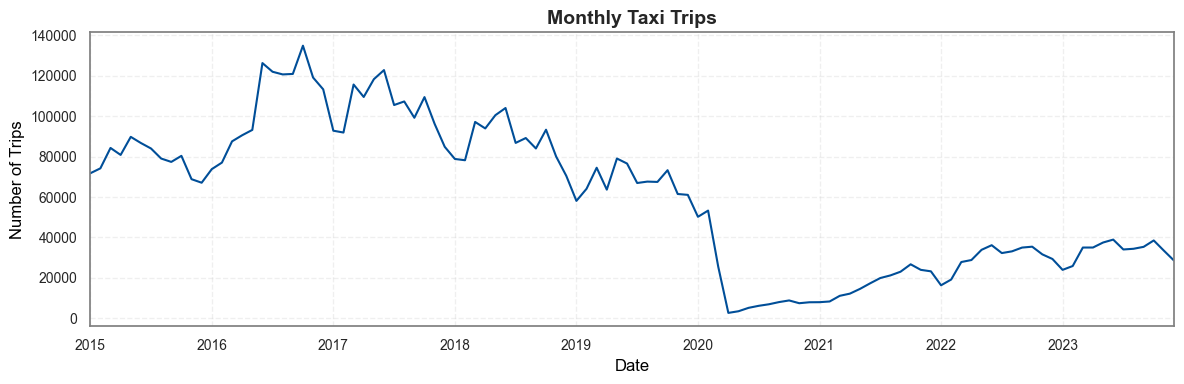

In [17]:
monthly_trips = (
    df.groupby(["start_year", "start_month"])
    .size()
    .rename("trip_count")
    .reset_index()
)

monthly_trips_for_date = monthly_trips[["start_year", "start_month"]].copy()
monthly_trips_for_date.columns = ["year", "month"]
monthly_trips_for_date["day"] = 1

monthly_trips["year_month"] = pd.to_datetime(monthly_trips_for_date)

monthly_trips.set_index("year_month")["trip_count"].plot(
    figsize=(12, 4),
    title="Monthly Taxi Trips", 
    color=PRIMARY_BLUE
)
plt.ylabel("Number of Trips")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

Interactive plot for website

In [18]:
source_df = df_cleaned.copy()
source_df = source_df.dropna(subset=["start_year", "start_month", "Company", "Tolls", "Extras"])

source_df["year_month"] = pd.to_datetime({
    "year": source_df["start_year"],
    "month": source_df["start_month"],
    "day": 1
})

monthly_trips = (
    source_df.groupby("year_month")
    .size()
    .reset_index(name="trip_count")
)

source = ColumnDataSource(monthly_trips.copy())
original_data = monthly_trips.copy()

p = figure(x_axis_type="datetime", title="Monthly Taxi Trips", height=400, width=800)
p.line(x='year_month', y='trip_count', source=source, line_width=2, color="navy")

company_select = Select(title="Company", value="All", options=["All"] + source_df['Company'].value_counts().head(10).index.tolist())

filter_checkboxes = CheckboxGroup(labels=["Exclude Tolls", "Exclude Extras"], active=[])

filter_df = source_df.copy()
filter_df = filter_df[["year_month", "Company", "Tolls", "Extras"]]
filter_df["trip_count"] = 1

filtered_monthly = (
    filter_df.groupby(["year_month", "Company", "Tolls", "Extras"])
    .size()
    .reset_index(name="trip_count")
)

callback = CustomJS(args=dict(source=source,
                              full=filtered_monthly,
                              company_select=company_select,
                              checkboxes=filter_checkboxes),
code="""
    const company = company_select.value;
    const excludeTolls = checkboxes.active.includes(0);
    const excludeExtras = checkboxes.active.includes(1);

    const full_data = full.data;
    const result = {};

    const year_month = [], trip_count = [];
    const counts = {};

    for (let i = 0; i < full_data['year_month'].length; i++) {
        const c = full_data['Company'][i];
        const toll = full_data['Tolls'][i];
        const extra = full_data['Extras'][i];
        const ym = full_data['year_month'][i];

        const matchCompany = company === "All" || c === company;
        const matchTolls = !excludeTolls || toll === 0;
        const matchExtras = !excludeExtras || extra === 0;

        if (matchCompany && matchTolls && matchExtras) {
            if (!(ym in counts)) {
                counts[ym] = 0;
            }
            counts[ym] += 1;
        }
    }

    for (const [key, val] of Object.entries(counts)) {
        year_month.push(key);
        trip_count.push(val);
    }

    source.data = { year_month, trip_count };
    source.change.emit();
""")

company_select.js_on_change('value', callback)
filter_checkboxes.js_on_change('active', callback)

layout = column(p, row(company_select, filter_checkboxes))
output_file("interactive_monthly_trips.html")
show(layout)


C. Tip behavior

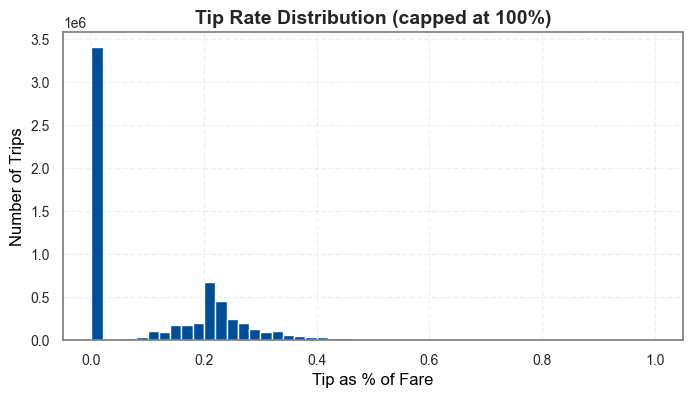

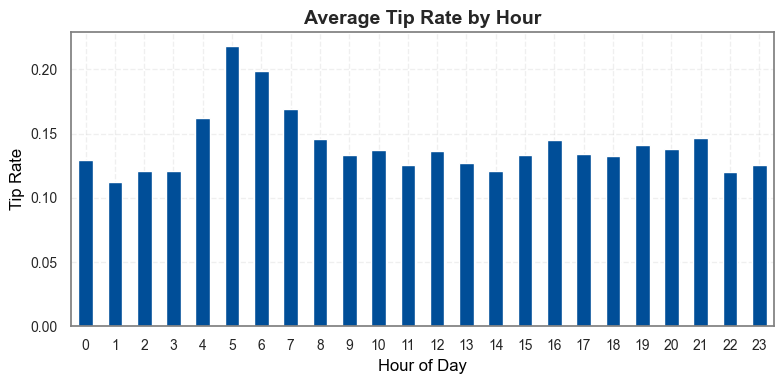

In [19]:
df["tip_rate"].clip(upper=1).hist(bins=50, figsize=(8,4), color=PRIMARY_BLUE)
plt.title("Tip Rate Distribution (capped at 100%)")
plt.xlabel("Tip as % of Fare")
plt.ylabel("Number of Trips")
plt.show()

hourly_tip = df.groupby("start_hour")["tip_rate"].mean()
hourly_tip.plot(kind="bar", title="Average Tip Rate by Hour", color=PRIMARY_BLUE)
plt.ylabel("Tip Rate")
plt.xlabel("Hour of Day")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


D. Speed outliers

In [20]:
fast_trips = df[df["avg_speed_mph"] > 70]

print("Trips faster than 70 mph:", len(fast_trips))
print(fast_trips[["Trip Miles", "trip_duration_min", "avg_speed_mph"]].head())

df = df[(df["avg_speed_mph"] > 0) & (df["avg_speed_mph"] < 100)]

Trips faster than 70 mph: 9836
       Trip Miles  trip_duration_min  avg_speed_mph
1392         7.00              15.00          84.00
2485        12.02              15.00          71.64
11085       24.80              15.00         135.27
12544        6.00              15.00          90.00
13999       32.10              30.00          80.25


E. Trip distribution by weekday

In [21]:
df.columns

Index(['Trip Start Timestamp', 'Trip End Timestamp', 'Trip Seconds',
       'Trip Miles', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total',
       'Payment Type', 'Company', 'Pickup Centroid Latitude',
       'Pickup Centroid Longitude', 'Dropoff Centroid Latitude',
       'Dropoff Centroid Longitude', 'trip_duration_min', 'avg_speed_mph',
       'tip_rate', 'start_year', 'start_month', 'start_hour', 'start_weekday',
       'end_year', 'end_month', 'end_hour', 'end_weekday'],
      dtype='object')

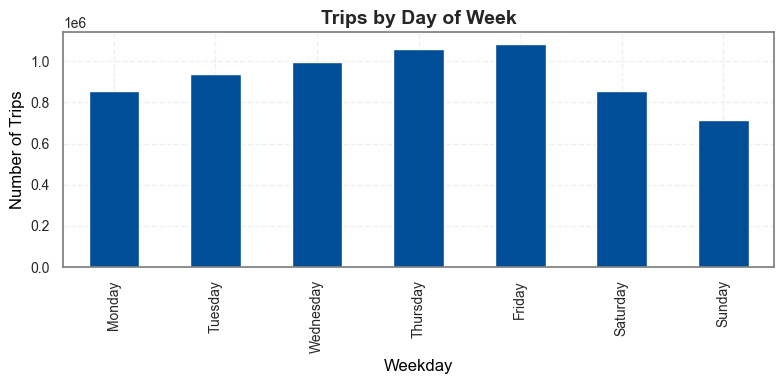

In [22]:
weekday_summary = df["start_weekday"].value_counts().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

weekday_summary.plot(kind="bar", title="Trips by Day of Week", color=PRIMARY_BLUE)
plt.ylabel("Number of Trips")
plt.xlabel("Weekday")
plt.tight_layout()
plt.show()


F. Map of pickup locations (if lat/lon available)

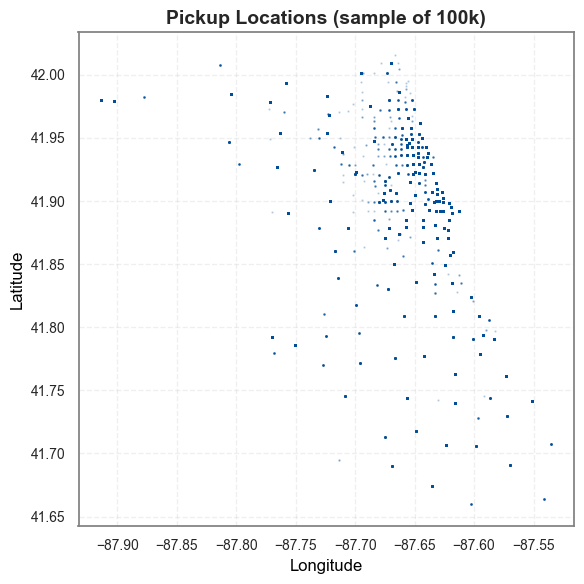

In [23]:
pickup_sample = df.dropna(subset=["Pickup Centroid Latitude", "Pickup Centroid Longitude"]).sample(n=100000, random_state=1)

plt.figure(figsize=(6, 6))
plt.scatter(
    pickup_sample["Pickup Centroid Longitude"],
    pickup_sample["Pickup Centroid Latitude"],
    s=0.5, alpha=0.2, color=PRIMARY_BLUE
)
plt.title("Pickup Locations (sample of 100k)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


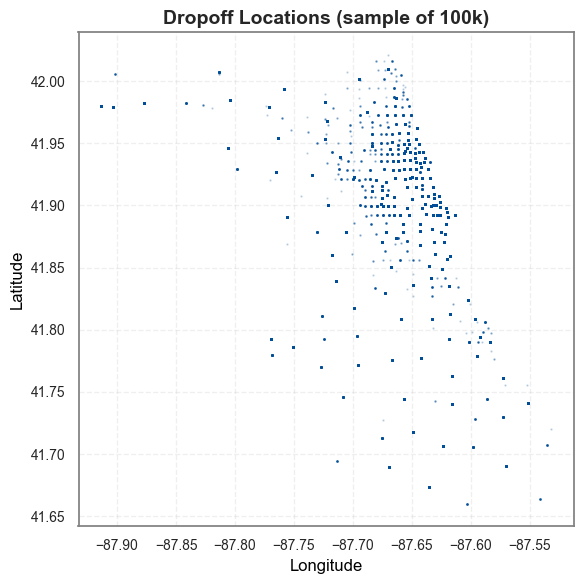

In [24]:
dropoff_sample = df.dropna(subset=["Dropoff Centroid Latitude", "Dropoff Centroid Longitude"]).sample(n=100000, random_state=1)

plt.figure(figsize=(6, 6))
plt.scatter(
    dropoff_sample["Dropoff Centroid Longitude"],
    dropoff_sample["Dropoff Centroid Latitude"],
    s=0.5, alpha=0.2, color=PRIMARY_BLUE
)
plt.title("Dropoff Locations (sample of 100k)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


Trip duration vs. distance (does time scale with miles?)

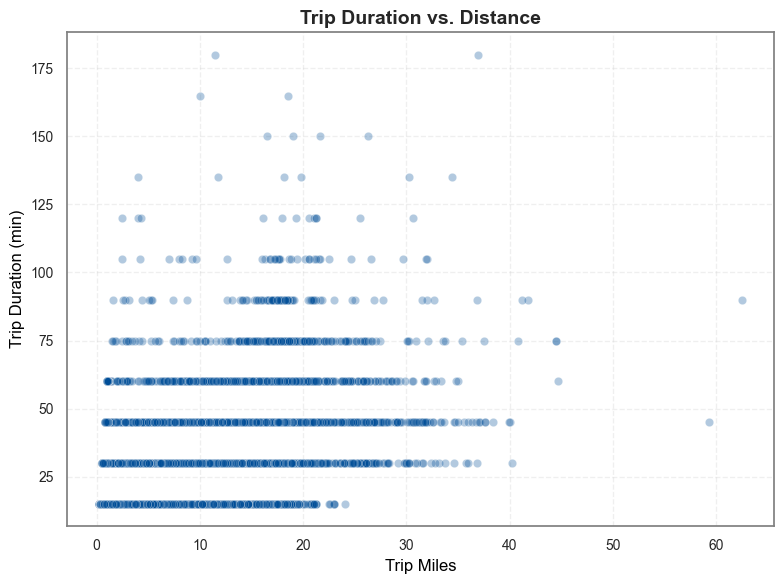

In [25]:
# Filter out zeros or NaNs
df_scatter = df[(df["Trip Miles"] > 0) & (df["trip_duration_min"] > 0)]

# Sample for plotting speed
df_sample = df_scatter.sample(n=50_000, random_state=1)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_sample,
    x="Trip Miles", y="trip_duration_min", alpha=0.3, color=PRIMARY_BLUE
)
plt.title("Trip Duration vs. Distance")
plt.xlabel("Trip Miles")
plt.ylabel("Trip Duration (min)")
plt.tight_layout()
plt.show()


Top companies by trip count and average fare

                                 trip_count  avg_fare  avg_tip
Company                                                       
Flash Cab                           1041156     18.66     1.58
Taxi Affiliation Services           1025989     19.28     2.23
Yellow Cab                           509270     15.50     1.61
Chicago Carriage Cab Corp            467308     17.09     2.10
Sun Taxi                             395743     19.36     2.81
City Service                         382981     18.73     2.55
Medallion Leasin                     312074     18.34     2.30
Choice Taxi Association              266317     17.66     2.50
Dispatch Taxi Affiliation            254498     15.39     1.84
Taxi Affiliation Service Yellow      210814     17.28     2.03
Globe Taxi                           168014     18.13     2.35
Star North Management LLC            140045     16.58     2.27
American United                      114457     15.41     1.59
Northwest Management LLC              97041     14.66  

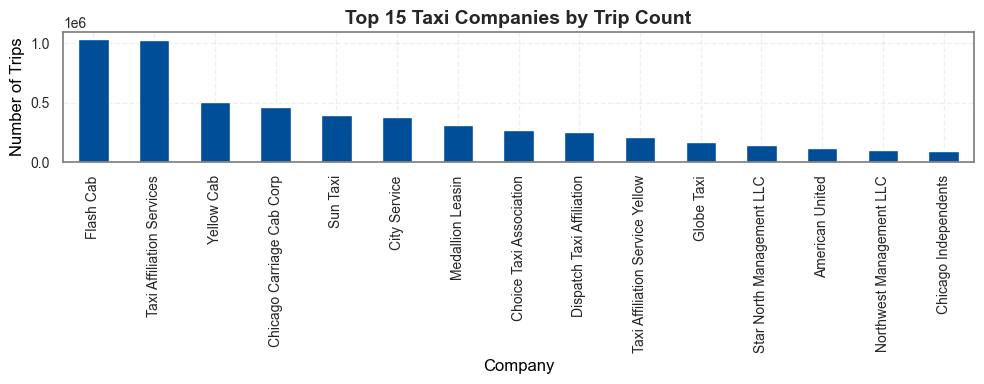

In [26]:
company_stats = (
    df.groupby("Company")
    .agg(
        trip_count = ("Trip Total", "count"),
        avg_fare = ("Fare", "mean"),
        avg_tip = ("Tips", "mean")
    )
    .sort_values("trip_count", ascending=False)
    .head(15)
)

print(company_stats)

# Plot top 15 companies by trip count
company_stats["trip_count"].plot(kind="bar", figsize=(10,4), title="Top 15 Taxi Companies by Trip Count", color=PRIMARY_BLUE)
plt.ylabel("Number of Trips")
plt.xlabel("Company")
plt.tight_layout()
plt.show()


Trips by payment type

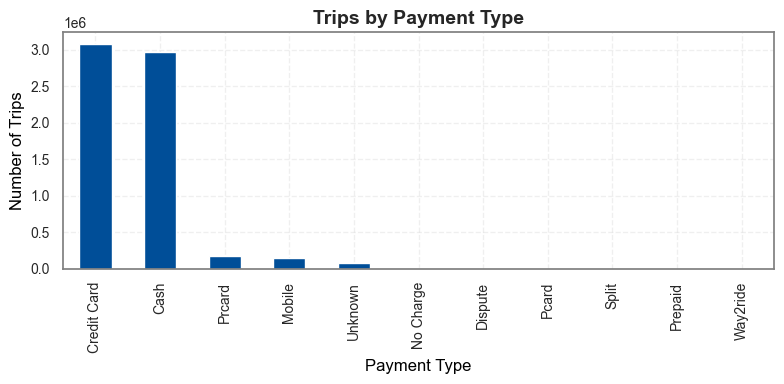

In [27]:
payment_summary = df["Payment Type"].value_counts()

payment_summary.plot(kind="bar", title="Trips by Payment Type", color=PRIMARY_BLUE)
plt.ylabel("Number of Trips")
plt.xlabel("Payment Type")
plt.tight_layout()
plt.show()


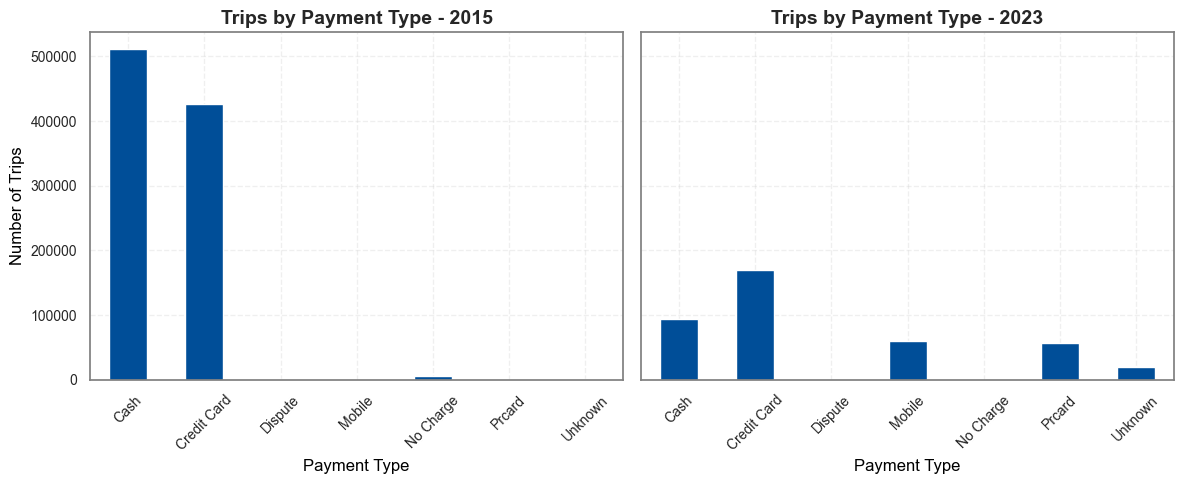

In [28]:
df_2015 = df_cleaned[df_cleaned["start_year"] == 2015]
df_2023 = df_cleaned[df_cleaned["start_year"] == 2023]

payment_2015 = df_2015["Payment Type"].value_counts()
payment_2023 = df_2023["Payment Type"].value_counts()

all_payment_types = sorted(set(payment_2015.index).union(payment_2023.index))
payment_2015 = payment_2015.reindex(all_payment_types, fill_value=0)
payment_2023 = payment_2023.reindex(all_payment_types, fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

payment_2015.plot(kind="bar", ax=axes[0], color=PRIMARY_BLUE)
axes[0].set_title("Trips by Payment Type - 2015")
axes[0].set_ylabel("Number of Trips")
axes[0].set_xlabel("Payment Type")
axes[0].tick_params(axis="x", rotation=45)

payment_2023.plot(kind="bar", ax=axes[1], color=PRIMARY_BLUE)
axes[1].set_title("Trips by Payment Type - 2023")
axes[1].set_ylabel("")
axes[1].set_xlabel("Payment Type")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


Heatmap: hour vs. weekday (when are people riding?)

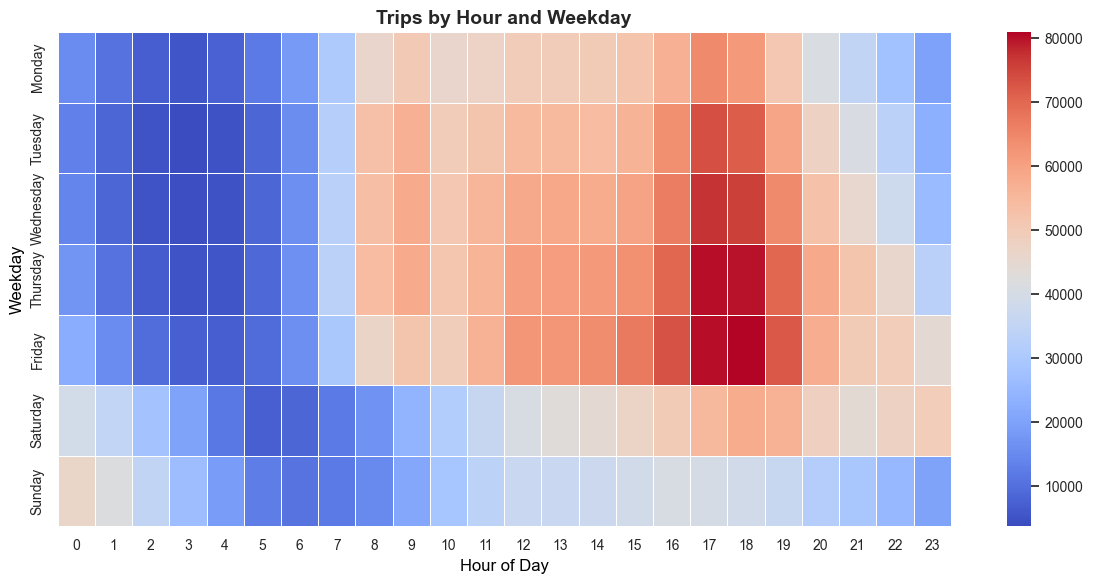

In [29]:
heatmap_data = (
    df.groupby(["start_weekday", "start_hour"])
    .size()
    .unstack()
    .reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Trips by Hour and Weekday")
plt.xlabel("Hour of Day")
plt.ylabel("Weekday")
plt.tight_layout()
plt.show()


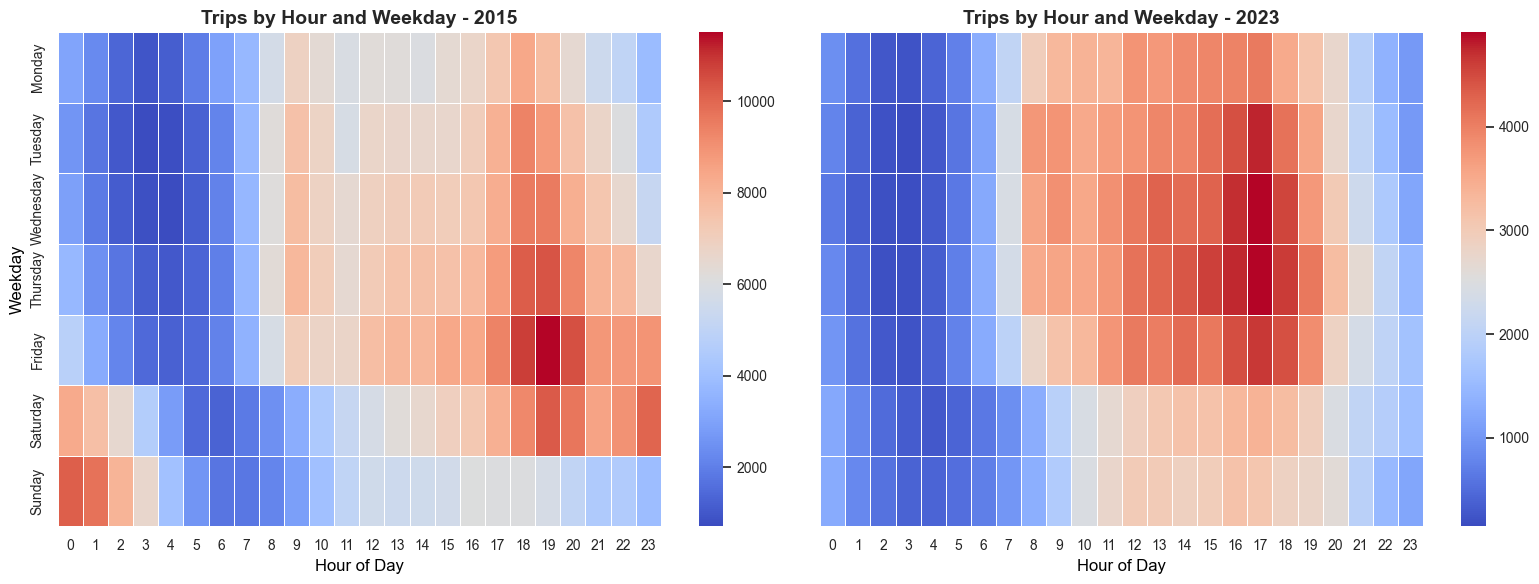

In [ ]:
df_2015 = df_cleaned[df_cleaned["start_year"] == 2015]
df_2023 = df_cleaned[df_cleaned["start_year"] == 2023]

order_weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

heatmap_2015 = (
    df_2015.groupby(["start_weekday", "start_hour"])
    .size()
    .unstack()
    .reindex(order_weekdays)
)

heatmap_2023 = (
    df_2023.groupby(["start_weekday", "start_hour"])
    .size()
    .unstack()
    .reindex(order_weekdays)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.heatmap(
    heatmap_2015,
    cmap="coolwarm",
    annot=False,
    linewidths=0.5,
    ax=axes[0]
)
axes[0].set_title("Trips by Hour and Weekday - 2015")
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Weekday")

sns.heatmap(
    heatmap_2023,
    cmap="coolwarm",
    annot=False,
    linewidths=0.5,
    ax=axes[1]
)
axes[1].set_title("Trips by Hour and Weekday - 2023")
axes[1].set_xlabel("Hour of Day")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


Detect unusually short or long trips

In [31]:
# Very short trips (<1 minute or <0.1 miles)
short_trips = df[(df["trip_duration_min"] < 1) | (df["Trip Miles"] < 0.1)]
print("Unusually short trips:", len(short_trips))

# Very long trips (>120 minutes or >50 miles)
long_trips = df[(df["trip_duration_min"] > 120) | (df["Trip Miles"] > 50)]
print("Unusually long trips:", len(long_trips))


Unusually short trips: 0
Unusually long trips: 2796


## 3.2 Temporal Patterns
- (monthly trends, weekday/hourly variation)

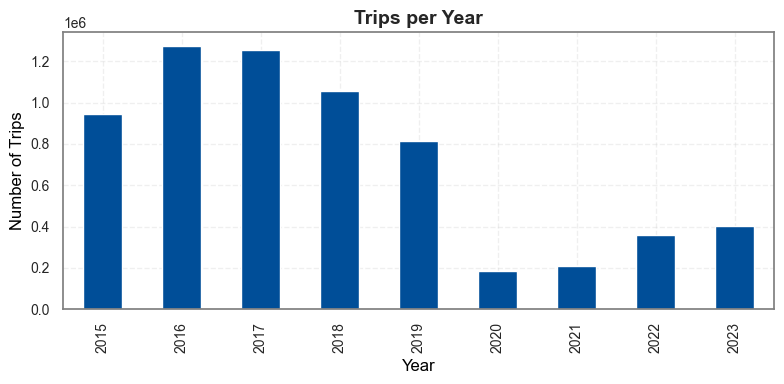

In [32]:
yearly = (
    df
    .groupby(df["Trip Start Timestamp"].dt.year)
    .size()
    .rename("num_trips")
)

yearly.plot(kind="bar", figsize=(8, 4), title="Trips per Year", color=PRIMARY_BLUE)
plt.ylabel("Number of Trips")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

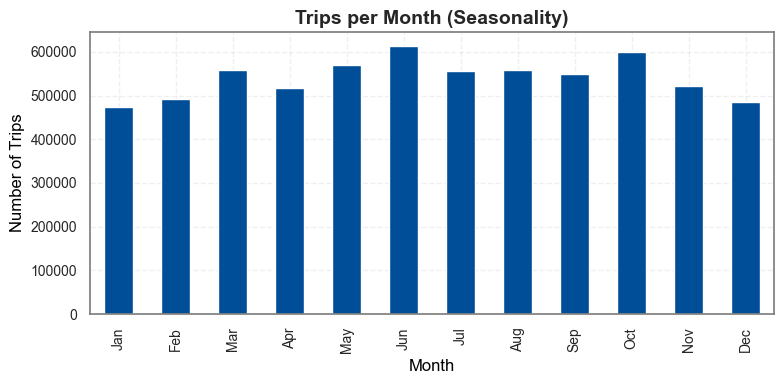

In [33]:
monthly = (
    df
    .groupby(df["Trip Start Timestamp"].dt.month)
    .size()
    .rename("num_trips")
)

monthly.index = [
    "Jan", "Feb", "Mar", "Apr", "May", "Jun", 
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
]

monthly.plot(kind="bar", figsize=(8, 4), title="Trips per Month (Seasonality)", color=PRIMARY_BLUE)
plt.ylabel("Number of Trips")
plt.xlabel("Month")
plt.tight_layout()
plt.show()


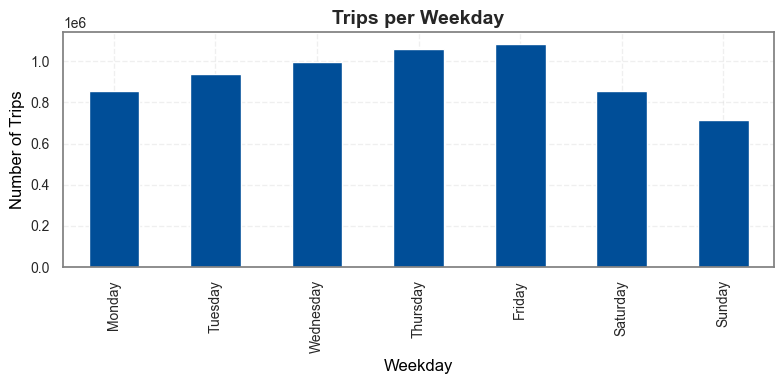

In [34]:
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

weekday = (
    df["start_weekday"]
    .value_counts()
    .reindex(weekday_order)
)

weekday.plot(kind="bar", figsize=(8, 4), title="Trips per Weekday", color=PRIMARY_BLUE)
plt.ylabel("Number of Trips")
plt.xlabel("Weekday")
plt.tight_layout()
plt.show()


## 3.3 Company Behavior
- (who dominates the market? who gets tipped more?)

In [35]:
company_stats = (
    df_cleaned.groupby("Company")
    .agg(
        trip_count=("Trip Total", "count"),
        avg_fare=("Fare", "mean"),
        avg_tip_rate=("tip_rate", "mean")
    )
    .sort_values("trip_count", ascending=False)
)

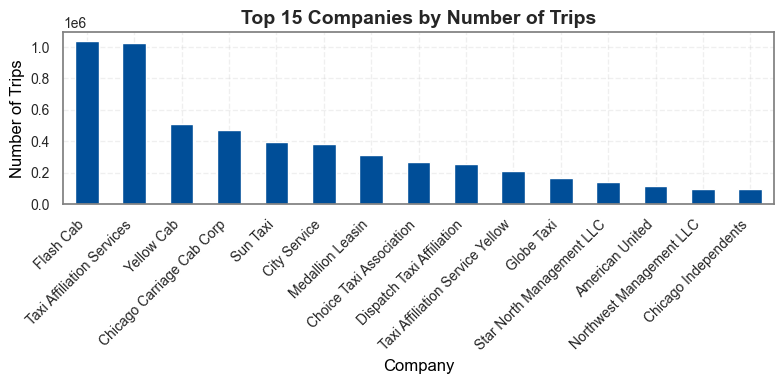

In [36]:
top15 = company_stats.head(15)

ax = top15["trip_count"].plot(kind="bar", color=PRIMARY_BLUE)
ax.set_title("Top 15 Companies by Number of Trips")
ax.set_ylabel("Number of Trips")
ax.set_xlabel("Company")
ax.set_xticklabels(top15.index, rotation=45, ha="right")
plt.tight_layout()
plt.show()


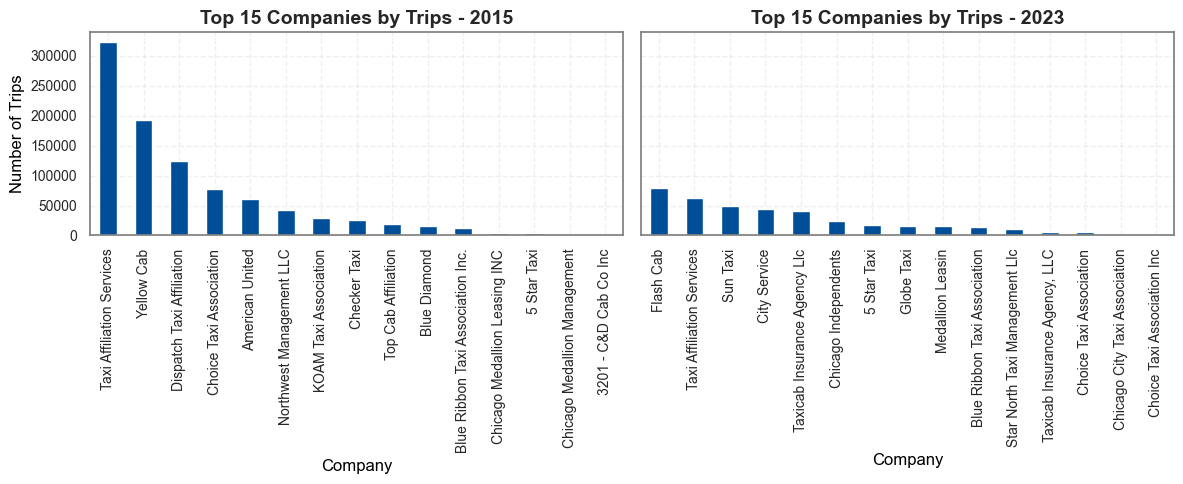

In [37]:
df_2015 = df_cleaned[df_cleaned["start_year"] == 2015]
df_2023 = df_cleaned[df_cleaned["start_year"] == 2023]

company_2015 = (
    df_2015.groupby("Company")
    .size()
    .rename("trip_count")
    .sort_values(ascending=False)
    .head(15)
)

company_2023 = (
    df_2023.groupby("Company")
    .size()
    .rename("trip_count")
    .sort_values(ascending=False)
    .head(15)
)
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# 2015
company_2015.plot(kind="bar", ax=axes[0], color=PRIMARY_BLUE)
axes[0].set_title("Top 15 Companies by Trips - 2015")
axes[0].set_xlabel("Company")
axes[0].set_ylabel("Number of Trips")
axes[0].tick_params(axis="x")

# 2023
company_2023.plot(kind="bar", ax=axes[1], color=PRIMARY_BLUE)
axes[1].set_title("Top 15 Companies by Trips - 2023")
axes[1].set_xlabel("Company")
axes[1].tick_params(axis="x")

plt.tight_layout()
plt.show()


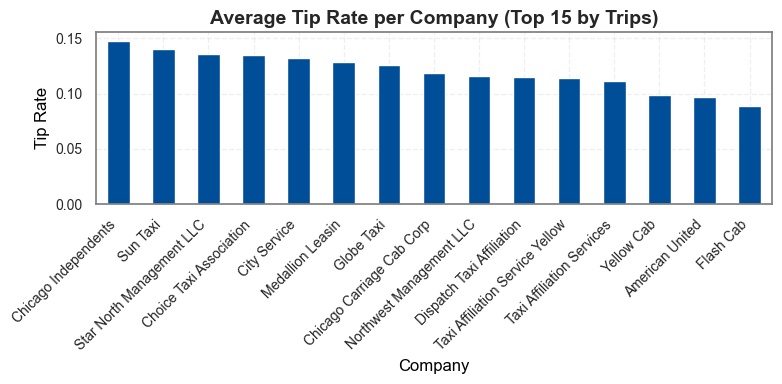

In [38]:
top15_sorted_by_tip = top15.sort_values("avg_tip_rate", ascending=False)

ax = top15_sorted_by_tip["avg_tip_rate"].plot(kind="bar", color=PRIMARY_BLUE)
ax.set_title("Average Tip Rate per Company (Top 15 by Trips)")
ax.set_ylabel("Tip Rate")
ax.set_xlabel("Company")
ax.set_xticklabels(top15_sorted_by_tip.index, rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [39]:
filtered = company_stats[company_stats["trip_count"] > 10_000].copy()
filtered["Company"] = filtered.index

fig = px.scatter(
    filtered,
    x="trip_count",
    y="avg_tip_rate",
    size="avg_fare",
    color="Company",
    hover_name="Company",
    title="Company Popularity vs. Tip Rate (Bubble Size = Avg Fare)"
)
fig.update_traces(
    hovertemplate=(
        "<b>%{hovertext}</b><br>" +
        "Trips: %{x:,}<br>" +
        "Avg Tip Rate: %{y:.2%}<br>" +
        "Avg Fare: %{marker.size:.2f}<extra></extra>"
    )
)

fig.update_layout(
    xaxis_title="Number of Trips",
    yaxis_title="Average Tip Rate",
    template="simple_white",
    font=dict(size=12),
    legend_title_text="Company"
)

fig.show()
fig.write_html("company_tip_rate_scatter.html", include_plotlyjs="cdn", full_html=True)

## 3.4 Geographic Spread 
- pickup/dropoff density

In [40]:
df_geo = df_cleaned.dropna(subset=[
    "Pickup Centroid Latitude", "Pickup Centroid Longitude",
    "Dropoff Centroid Latitude", "Dropoff Centroid Longitude"
])

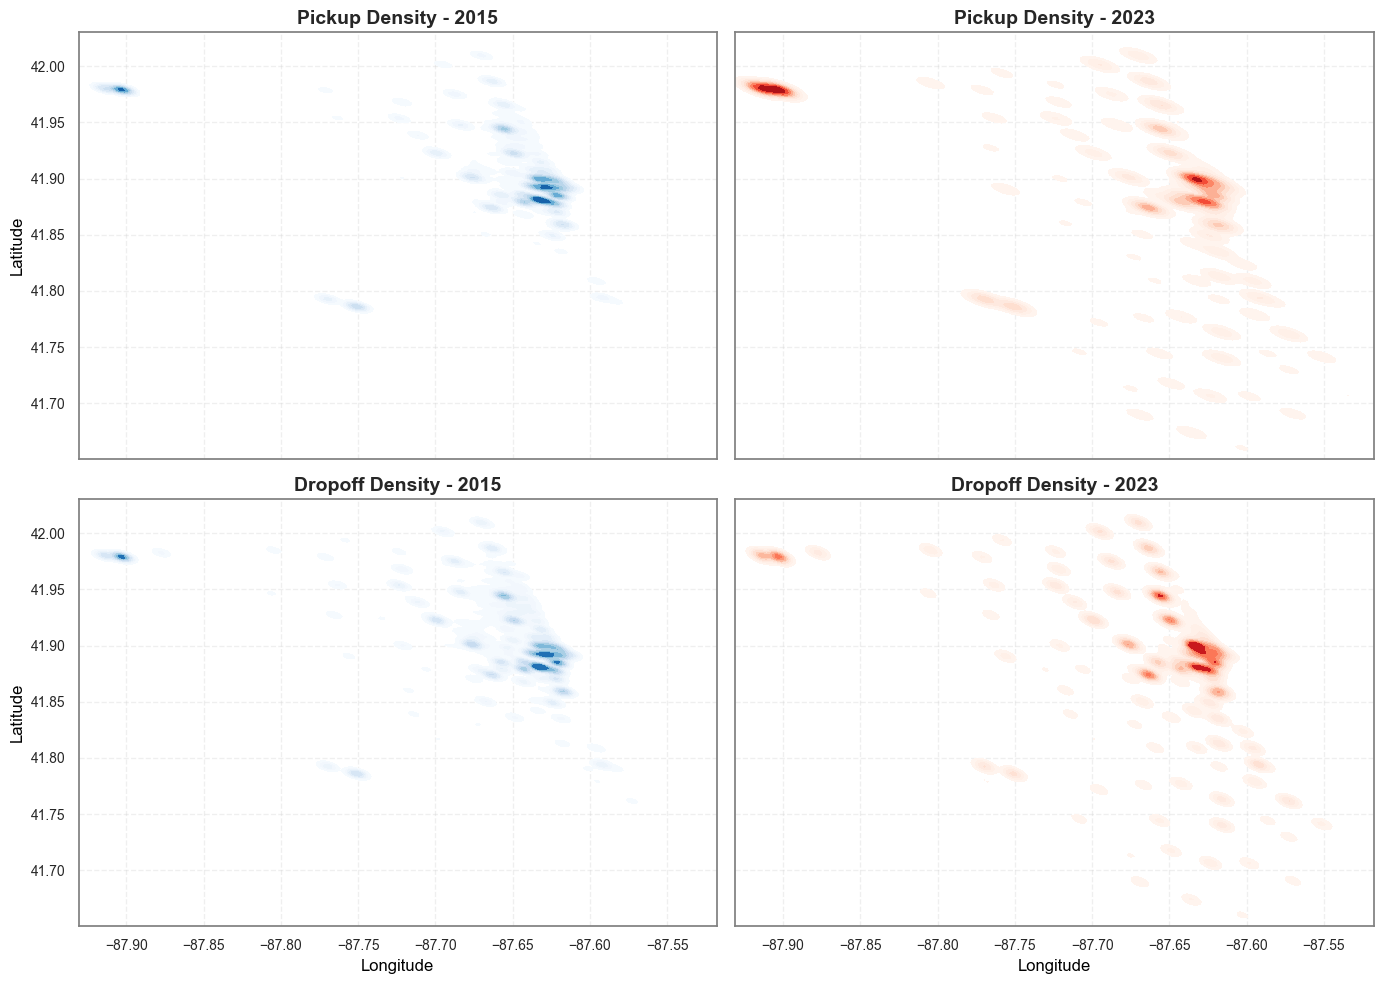

In [41]:
pickup_2015 = df_geo[df_geo["start_year"] == 2015].sample(50_000, random_state=1)
pickup_2023 = df_geo[df_geo["start_year"] == 2023].sample(50_000, random_state=2)
dropoff_2015 = df_geo[df_geo["start_year"] == 2015].sample(50_000, random_state=3)
dropoff_2023 = df_geo[df_geo["start_year"] == 2023].sample(50_000, random_state=4)

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

# Pickup 2015
sns.kdeplot(
    data=pickup_2015, ax=axes[0, 0],
    x="Pickup Centroid Longitude", y="Pickup Centroid Latitude",
    cmap="Blues", fill=True, thresh=0.05, bw_adjust=0.3
)
axes[0, 0].set_title("Pickup Density - 2015")

# Pickup 2023
sns.kdeplot(
    data=pickup_2023, ax=axes[0, 1],
    x="Pickup Centroid Longitude", y="Pickup Centroid Latitude",
    cmap="Reds", fill=True, thresh=0.05, bw_adjust=0.3
)
axes[0, 1].set_title("Pickup Density - 2023")

# Dropoff 2015
sns.kdeplot(
    data=dropoff_2015, ax=axes[1, 0],
    x="Dropoff Centroid Longitude", y="Dropoff Centroid Latitude",
    cmap="Blues", fill=True, thresh=0.05, bw_adjust=0.3
)
axes[1, 0].set_title("Dropoff Density - 2015")

# Dropoff 2023
sns.kdeplot(
    data=dropoff_2023, ax=axes[1, 1],
    x="Dropoff Centroid Longitude", y="Dropoff Centroid Latitude",
    cmap="Reds", fill=True, thresh=0.05, bw_adjust=0.3
)
axes[1, 1].set_title("Dropoff Density - 2023")

for ax in axes.flat:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()


In [45]:
pickup_sample = df_geo[df_geo["start_year"] == 2023][["Pickup Centroid Latitude", "Pickup Centroid Longitude"]].dropna().sample(20000, random_state=1)
dropoff_sample = df_geo[df_geo["end_year"] == 2023][["Dropoff Centroid Latitude", "Dropoff Centroid Longitude"]].dropna().sample(20000, random_state=2)

pickup_sample.columns = ["lat", "lon"]
dropoff_sample.columns = ["lat", "lon"]

pickup_sample["Type"] = "Pickup"
dropoff_sample["Type"] = "Dropoff"

map_data = pd.concat([pickup_sample, dropoff_sample])
fig = px.scatter_mapbox(
    map_data,
    lat="lat",
    lon="lon",
    color="Type",
    zoom=10,
    height=500,
    opacity=0.5,
    title="Interactive Map of Pickups and Dropoffs (2023)",
    mapbox_style="carto-positron"
)

fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()
fig.write_html("pickup_dropoff_map_2023.html")

## 3.5 Fare, Duration, Distance Distributions

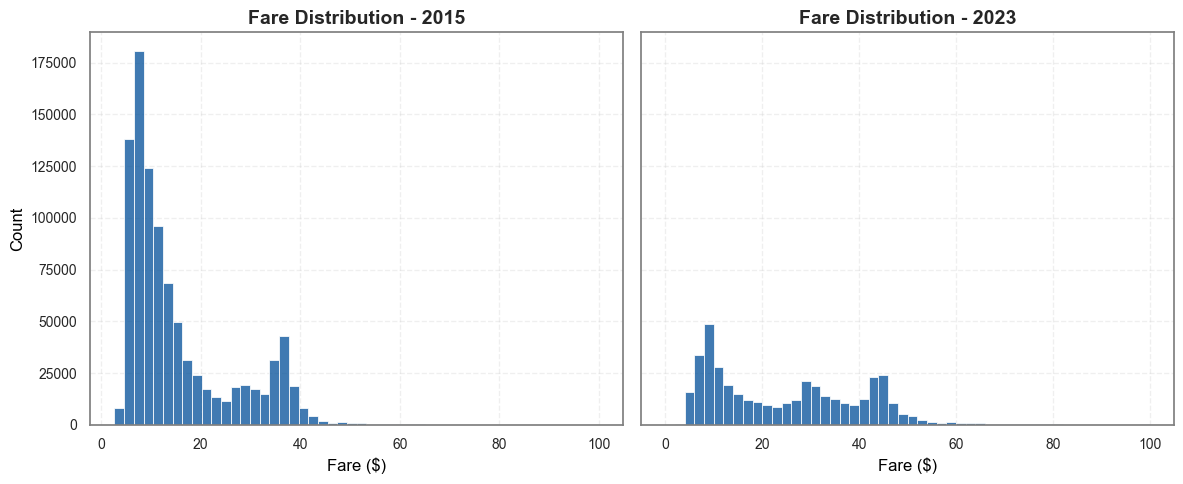

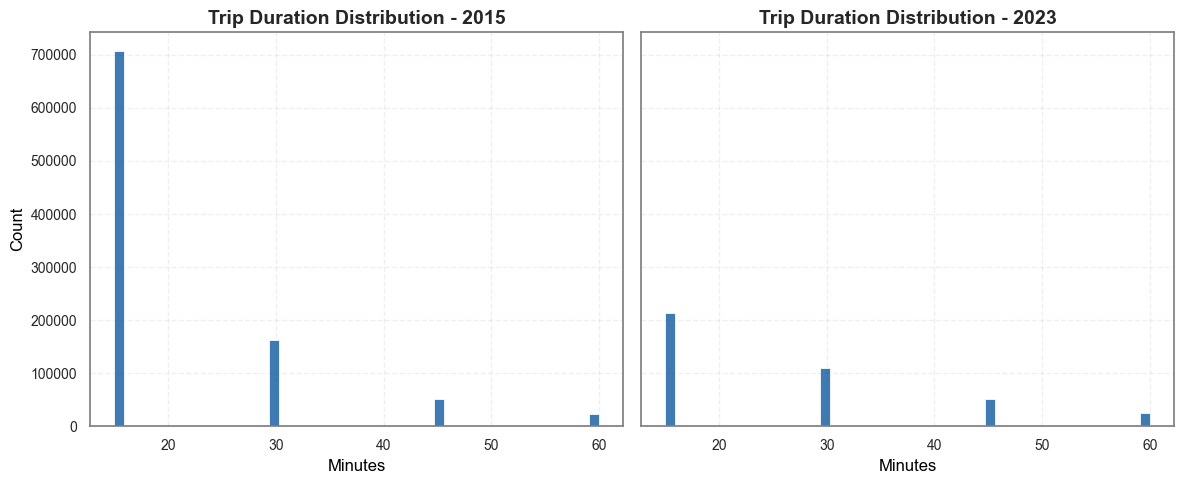

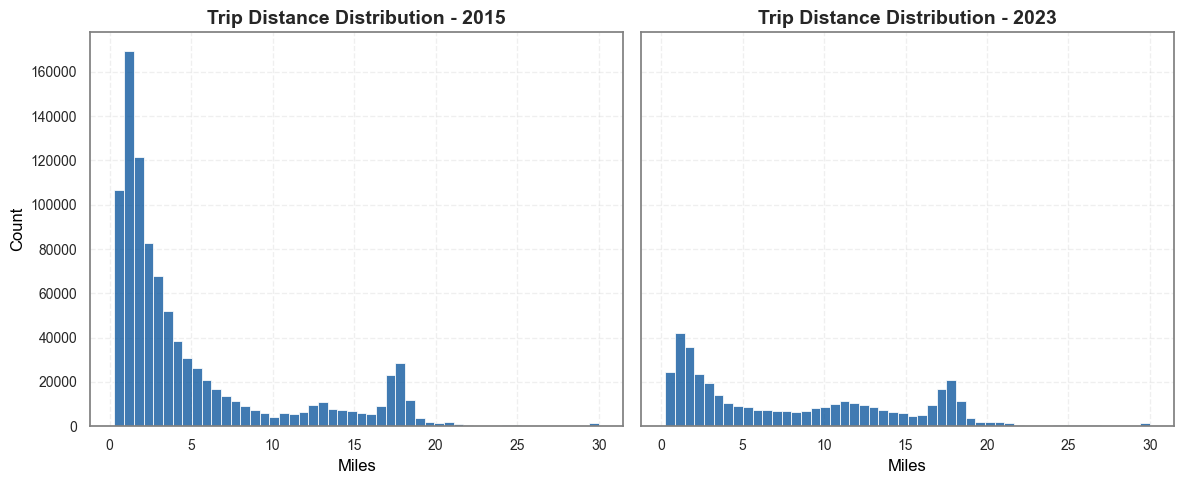

In [46]:
df_2015 = df_cleaned[df_cleaned["start_year"] == 2015].copy()
df_2023 = df_cleaned[df_cleaned["start_year"] == 2023].copy()

df_2015["Fare Capped"] = df_2015["Fare"].clip(upper=100)
df_2023["Fare Capped"] = df_2023["Fare"].clip(upper=100)

df_2015["Duration Capped"] = df_2015["trip_duration_min"].clip(upper=60)
df_2023["Duration Capped"] = df_2023["trip_duration_min"].clip(upper=60)

df_2015["Distance Capped"] = df_2015["Trip Miles"].clip(upper=30)
df_2023["Distance Capped"] = df_2023["Trip Miles"].clip(upper=30)
def compare_distributions(var, label, unit, bins):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    sns.histplot(df_2015[var], bins=bins, ax=axes[0], color=PRIMARY_BLUE)
    axes[0].set_title(f"{label} Distribution - 2015")
    axes[0].set_xlabel(unit)
    axes[0].set_ylabel("Count")

    sns.histplot(df_2023[var], bins=bins, ax=axes[1], color=PRIMARY_BLUE)
    axes[1].set_title(f"{label} Distribution - 2023")
    axes[1].set_xlabel(unit)

    plt.tight_layout()
    plt.show()
compare_distributions("Fare Capped", "Fare", "Fare ($)", bins=50)
compare_distributions("Duration Capped", "Trip Duration", "Minutes", bins=50)
compare_distributions("Distance Capped", "Trip Distance", "Miles", bins=50)


# 3.6 Machine learning 
- Predicting total number of trips per year
- Predicting average fare per year

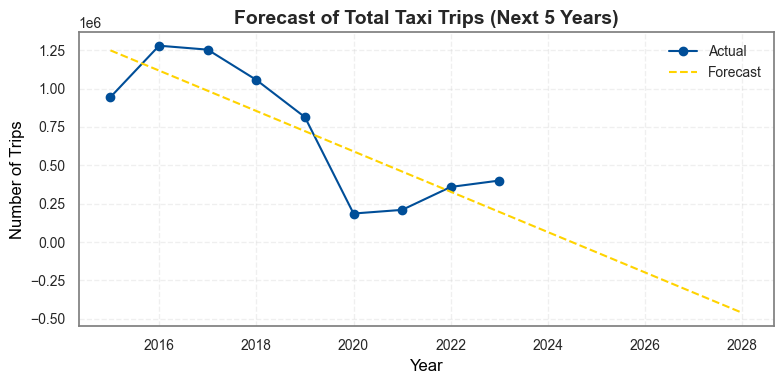

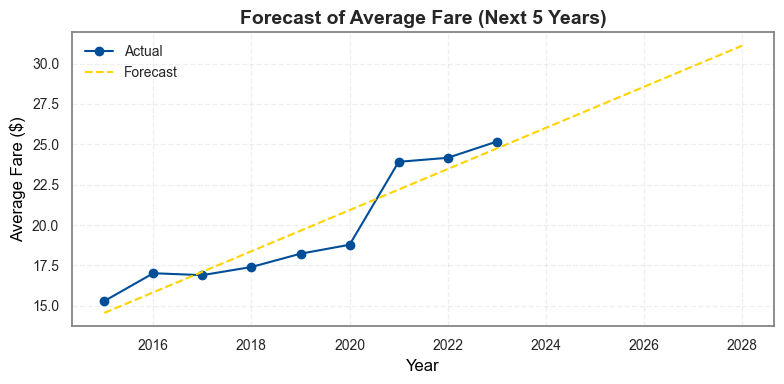

In [47]:
trips_per_year = (
    df_cleaned.groupby("start_year")
    .size()
    .rename("num_trips")
    .reset_index()
)

fare_per_year = (
    df_cleaned.groupby("start_year")["Fare"]
    .mean()
    .rename("avg_fare")
    .reset_index()
)

def fit_and_forecast(df, x_col, y_col, years_forward=5):
    model = LinearRegression()
    
    X = df[[x_col]].values
    y = df[y_col].values
    model.fit(X, y)
    
    last_year = df[x_col].max()
    future_years = np.arange(last_year + 1, last_year + 1 + years_forward)
    all_years = np.append(df[x_col].values, future_years)
    
    y_pred = model.predict(all_years.reshape(-1, 1))
    return all_years, y_pred
years_trips, predicted_trips = fit_and_forecast(trips_per_year, "start_year", "num_trips")

plt.figure(figsize=(8, 4))
plt.plot(trips_per_year["start_year"], trips_per_year["num_trips"], label="Actual", marker='o', color=PRIMARY_BLUE)
plt.plot(years_trips, predicted_trips, label="Forecast", linestyle="--", color=TAXI_YELLOW)
plt.title("Forecast of Total Taxi Trips (Next 5 Years)")
plt.xlabel("Year")
plt.ylabel("Number of Trips")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
years_fare, predicted_fare = fit_and_forecast(fare_per_year, "start_year", "avg_fare")

plt.figure(figsize=(8, 4))
plt.plot(fare_per_year["start_year"], fare_per_year["avg_fare"], label="Actual", marker='o', color=PRIMARY_BLUE)
plt.plot(years_fare, predicted_fare, label="Forecast", linestyle="--", color=TAXI_YELLOW)
plt.title("Forecast of Average Fare (Next 5 Years)")
plt.xlabel("Year")
plt.ylabel("Average Fare ($)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 6. Narrative Genre & Structure (from Segel & Heer)
We used a mixed genre of data story that blends both author-driven narrative and reader-driven interactivity. The overall structure is guided and linear like a magazine article, but some of the visualizations—like interactive maps and charts—let the user explore the data on their own. We wanted it to feel like scrolling through a digital article that has moments where users can stop, zoom in, and explore.

Visual Narrative Tools (Figure 7 — Segal & Heer)
1. Visual Structure
- We applied consistent formatting across plots: same color palette, gridlines, titles, and font sizes. KDE maps, heatmaps, and other plots follow the same layout style for easy comparison across years.

2. Interactivity
- We used interactive Plotly plots for scatter and map visualizations where users can hover, zoom, and pan. We also created a Bokeh-based line chart with dropdown and checkbox filters to dynamically adjust the data by company or fare type.

3. Messaging
- Each section starts with a short explanation, followed by a matching plot. Some sections also highlight surprising insights like tip rate heatmaps or forecasted trends. We also added custom hover labels for clarity.

Narrative Structure Tools (Figure 7 — Segal & Heer)
1. Author-driven
- The project follows a clear structure from motivation and preprocessing to exploratory data analysis, spatial analysis, behavior analysis, and forecasting. We guide the user through a story, from what’s happening to why it matters.

2. Reader-driven
- Interactive widgets let users filter the trip data. Maps and scatter plots can be explored freely, so users can dive into patterns that interest them. This is especially useful for visitors who want to compare specific companies or time periods.

3. Mixed Structure
- The project is mostly author-driven in layout and messaging, but includes embedded interactivity where it matters—like in the geographic spread or trend forecasting.

# 7. Visualizations
We used a combination of classic and interactive visualizations:

- Time series plots for tracking trip volume and fare changes over the years

- Side-by-side heatmaps for weekday/hour patterns in 2015 and 2023

- KDE density maps to show how pickup and dropoff locations evolved over time

- Interactive scatter plot showing trip count vs tip rate, with bubble size representing average fare

- Forecast plots using linear regression to predict future trends

- Bokeh line chart with filters to explore data by company and extras/tolls inclusion

- Map-based plots using Plotly to visualize pickup/dropoff locations on a city map

Each visualization was chosen to match a specific type of insight. For example, KDE maps are best for showing spatial distributions, while line plots help visualize trends over time. The heatmaps helped us see patterns across days and hours. Interactive plots (scatter and map) made it easier for users to dig deeper into specific companies or behaviors. Overall, we picked visual types that would be both informative and intuitive to a wide audience—especially users who might not be data experts but are curious about how their city moves.

# 8. Discussion
- What worked well?
    - At first, we had a lot of trouble just getting the dataset. It took us almost a week to successfully download it from the open data portal due to size limitations and connection issues. The full dataset contains over 100 million rows, and at the beginning we didn’t really know how to work with such large data. What ended up working well was our decision to sample the data—we took a random 10% from each chunk, which still gave us millions of rows to work with and a dataset that was representative enough for analysis.
    - Another thing that went well was our division of tasks. We structured the work into clear stages: first cleaning and sampling the data, then doing exploratory analysis, and finally creating visualizations. This workflow helped us stay organized. In particular, it worked well to focus on comparing 2015 and 2023, which made the results more meaningful and helped frame the story we wanted to tell.

- What would you improve (e.g., adding more external context)?
    - One thing we’d improve is adding more external context—like overlaying known events (e.g., COVID-19 lockdown dates or major holidays) to help explain sudden changes in trip volume or behavior. We also could’ve incorporated weather data or public transit disruptions to better understand why some days or times have more trips. Another idea is comparing with other cities or including population density maps to see how demand matches with urban layout. Lastly, the forecasting part could be expanded with more complex models if we had more computing time or used hourly/daily granularity instead of monthly.

# 9. Contributions
- Jakub: Initial dataset preprocessing, creating Jekyll site and writing the soty
- Mateusz: Performing analysis, creating graphs, plots, and explainer notebook